In [2]:
from utils import *

import os
import sys
sys.path.append(os.path.join(os.getcwd()))

import pickle
from torch import tensor
import torch
from torch.utils.data import DataLoader


from src.model.dataset import MaskRCNNDataset
from src.model.model import maskRCNNModel
from src.model.engine import FitterMaskRCNN


/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
weigts_dir = "/Volumes/Extreme_SSD/Gastrointestinal_voucher/weights/multirater"
# weigts_dir = "/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/weights"
multi_1_dir = os.path.join(weigts_dir, "1", )
multi_2_dir = os.path.join(weigts_dir, "2")
multi_all_dir = os.path.join(weigts_dir, "all")

test_dataset_path = "../dataset/test_multirater_consensus"
test_dataset = MaskRCNNDataset(dataset_path=test_dataset_path, datatype="eval", data_augmentation=None)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# dataset containing predictions from two different annotators
test_dataset_multi_path = "../dataset/test_multirater"
test_dataset_multi_1 = MaskRCNNDataset(dataset_path=test_dataset_multi_path, datatype="eval", data_augmentation=None, annotator=1)
test_dataset_multi_2 = MaskRCNNDataset(dataset_path=test_dataset_multi_path, datatype="eval", data_augmentation=None, annotator=2)
# Create target list
target = []
for _, t in test_dataset:
    del t["masks"]
    target.append(t)

# TODO choose the actual best models
best_10_1 = [28, 68, 37, 27, 72, 33, 74, 56, 57, 43]
# best_10_2 = [21, 66, 67, 64, 73, 65, 76, 26, 18, 58]
best_10_2 = [65, 22, 49, 51, 70, 47, 64, 21, 54, 56]
best_10_all = [14, 74, 16, 75, 55, 18, 65, 33, 66, 30]

fitter = FitterMaskRCNN() 



/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [4]:
def predict(model: maskRCNNModel, dataloader: DataLoader, fitter: FitterMaskRCNN):
    predictions, metric = fitter.evaluate_one_epoch_predictions(model, dataloader, confidence_threshold=0)
    for i, pred in enumerate(predictions):
        del pred["masks"]
    return predictions, metric

def predict_ensamble(weigts_dir: str, models_id: list, dataloader: DataLoader, fitter: FitterMaskRCNN):
    all_predictions = {}
    all_metrics = {}
    for i, model_id in enumerate(models_id):
        model_path = os.path.join(weigts_dir, f"best-checkpoint-{model_id}.bin")
        model = maskRCNNModel()
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['model_state_dict'])
        predictions, metric= predict(model, dataloader, fitter)
        all_predictions[i] = predictions
        all_metrics[i] = metric

    return all_predictions, all_metrics

# store the predictions
path = "multirater_predictions"
os.makedirs(path, exist_ok=True)
if not os.path.exists(os.path.join(path, "predictions_1.pkl")):
    predictions_1, metrics_1 = predict_ensamble(multi_1_dir, best_10_1, test_loader, fitter)
    print(predictions_1.keys())
    with open(os.path.join(path, "predictions_1.pkl"), "wb") as f:
        pickle.dump(predictions_1, f)
    with open(os.path.join(path, "metrics_1.pkl"), "wb") as f:
        pickle.dump(metrics_1, f)
else:
    predictions_1 = pickle.load(open(os.path.join(path, "predictions_1.pkl"), "rb"))
    metrics_1 = pickle.load(open(os.path.join(path, "metrics_1.pkl"), "rb"))

if not os.path.exists(os.path.join(path, "predictions_2.pkl")):
    predictions_2, metrics_2 = predict_ensamble(multi_2_dir, best_10_2, test_loader, fitter)
    with open(os.path.join(path, "predictions_2.pkl"), "wb") as f:
        pickle.dump(predictions_2, f)
    with open(os.path.join(path, "metrics_2.pkl"), "wb") as f:
        pickle.dump(metrics_2, f)
else:
    predictions_2 = pickle.load(open(os.path.join(path, "predictions_2.pkl"), "rb"))
    metrics_2 = pickle.load(open(os.path.join(path, "metrics_2.pkl"), "rb"))

if not os.path.exists(os.path.join(path, "predictions_all.pkl")):
    predictions_all, metrics_all = predict_ensamble(multi_all_dir, best_10_all, test_loader, fitter)
    with open(os.path.join(path, "predictions_all.pkl"), "wb") as f:
        pickle.dump(predictions_all, f)
    with open(os.path.join(path, "metrics_all.pkl"), "wb") as f:
        pickle.dump(metrics_all, f)
else:
    predictions_all = pickle.load(open(os.path.join(path, "predictions_all.pkl"), "rb"))
    metrics_all = pickle.load(open(os.path.join(path, "metrics_all.pkl"), "rb"))

print(type(predictions_all[0][0]["boxes"]))


<class 'torch.Tensor'>


# MAP of the best models on the test set

We test the MAP attanind by the selected models on bottstrapped vesions of the test set. Results hould show if there is a significant difference between the models.

**remark**: this should be done on the validation set

In [5]:
import random
n_bootstrap = 10
bootstrap_indices = {}
for i in range(n_bootstrap):
    bootstrap_indices[i] = random.choices(range(len(test_dataset)), k=len(test_dataset))
# rater 1
bootstrap_results_1 = {i: [] for i in range(len(best_10_1))}
for b_idx in tqdm(bootstrap_indices.keys()):
    indices = bootstrap_indices[b_idx]
    # gather target and predictions
    target_b = [test_dataset[i][1] for i in indices]
    predictions_b_ensamble = []
    for i in range(len(best_10_1)):
        predictions_b_i = [predictions_1[i][j] for j in indices]
        predictions_b_ensamble.append(predictions_b_i)
        # compute MAP for the model
        mAP = MeanAveragePrecision(iou_type="bbox", max_detection_thresholds= [10, 100, 1000])
        mAP.update(predictions_b_i, target_b)
        result = mAP.compute()
        bootstrap_results_1[i].append(result['map'].item())
        
print(bootstrap_results_1)
        

100%|██████████| 10/10 [02:15<00:00, 13.54s/it]

{0: [0.4441572427749634, 0.415207177400589, 0.4742434024810791, 0.46064576506614685, 0.42009875178337097, 0.46743345260620117, 0.48666274547576904, 0.38974592089653015, 0.4098100960254669, 0.3984965980052948], 1: [0.44782644510269165, 0.41601648926734924, 0.4756288230419159, 0.4635414481163025, 0.42070361971855164, 0.47087424993515015, 0.48791006207466125, 0.3920350670814514, 0.4115678369998932, 0.40094801783561707], 2: [0.4492538571357727, 0.4206157326698303, 0.477744996547699, 0.4660746455192566, 0.4228932857513428, 0.47560983896255493, 0.48979452252388, 0.39742955565452576, 0.41428929567337036, 0.4065663814544678], 3: [0.4446512758731842, 0.41313430666923523, 0.47371944785118103, 0.459150105714798, 0.4193230867385864, 0.46987780928611755, 0.4871070981025696, 0.39581722021102905, 0.40573596954345703, 0.3930269479751587], 4: [0.4470469653606415, 0.41947823762893677, 0.4800918400287628, 0.4653325080871582, 0.4237158000469208, 0.46957218647003174, 0.493502676486969, 0.38986533880233765,

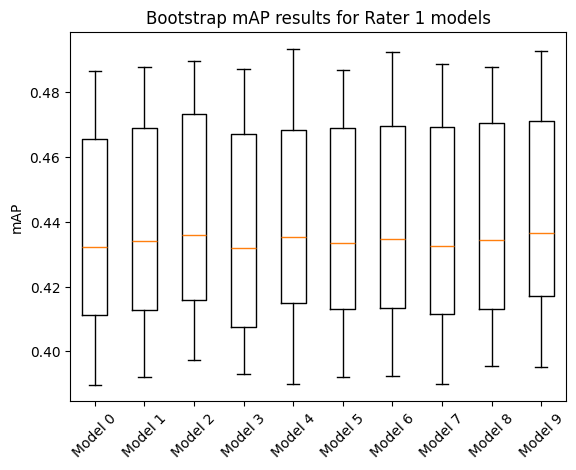

In [6]:
#plot the results as 10 different boxplots

plt.boxplot([bootstrap_results_1[i] for i in range(len(best_10_1))])
plt.xticks(ticks=range(1, len(best_10_1)+1), labels=[f"Model {i}" for i in range(len(best_10_1))], rotation=45)
plt.ylabel("mAP")
plt.title("Bootstrap mAP results for Rater 1 models")
plt.show()


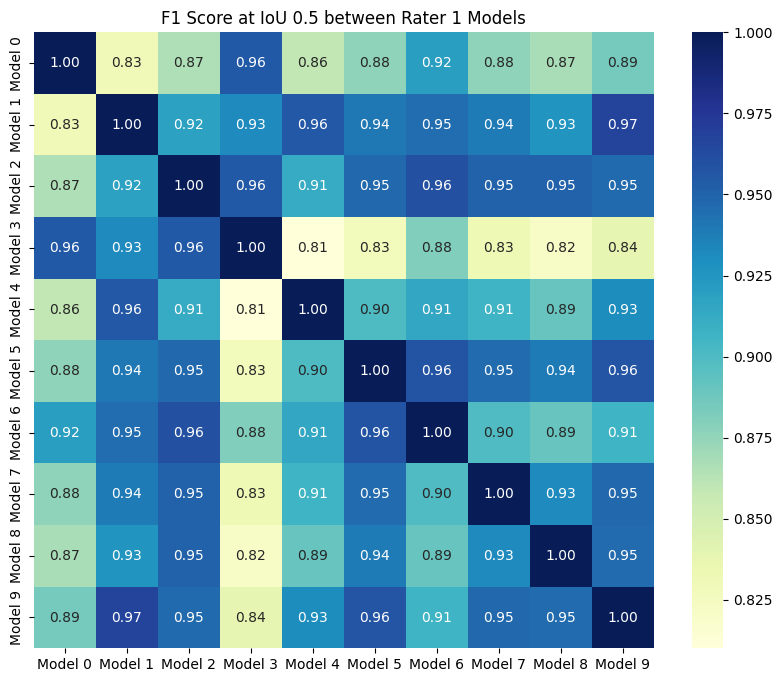

In [7]:
# compute the f1 score at IoU 0.5 betwen models to se variability in predictions
f1_scores = np.identity(len(best_10_1))
for i in range(len(best_10_1)):
    for j in range(i+1, len(best_10_1)):
        preds_i = predictions_1[i]
        preds_j = predictions_1[j]
        # compute mAP for the model
        mAP = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5], max_detection_thresholds= [10, 100, 1000])
        mAP.update(preds_i, preds_j)
        res = mAP.compute()
        precision = res['map_50']
        recall = res['mar_1000']

        # Get precision-recall curve

        # Compute F1 at each point (e.g., for IoU=0.5)
        import torch
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        f1_scores[i, j] = f1.item()
        f1_scores[j, i] = f1.item()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(f1_scores, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=[f"Model {i}" for i in range(len(best_10_1))], yticklabels=[f"Model {i}" for i in range(len(best_10_1))])
plt.title("F1 Score at IoU 0.5 between Rater 1 Models")
plt.show()
        

Diverse model indices for Rater 1: [3, 4, 8, 6, 7]


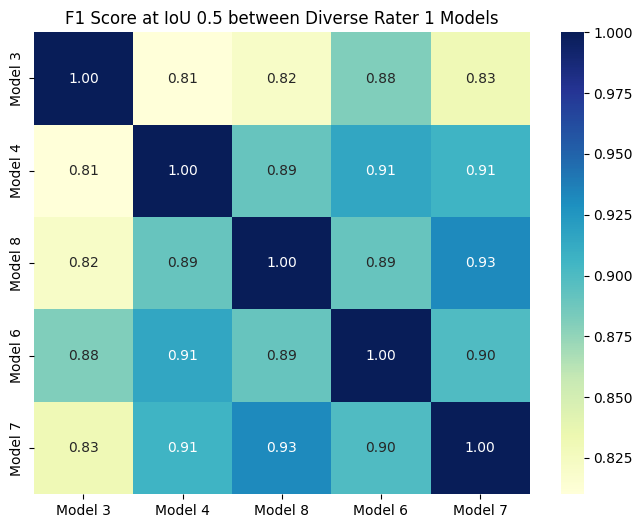

In [9]:
# coose the 5 most diverse models

def farthest_point_sampling(D, k, start_idx=None):
    N = D.shape[0]
    if start_idx is None:
        start_idx = np.argmax(D.sum(axis=1))
    S = [start_idx]
    while len(S) < k:
        min_dists = np.min(D[np.ix_(range(N), S)], axis=1)
        next_idx = np.argmax(min_dists)
        S.append(next_idx)
    return S

diverse_model_indices = farthest_point_sampling(1 - f1_scores, k=5)
print("Diverse model indices for Rater 1:", diverse_model_indices)

# plot the f1 scores heatmap only for the diverse models
plt.figure(figsize=(8, 6))
sns.heatmap(f1_scores[np.ix_(diverse_model_indices, diverse_model_indices)], annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=[f"Model {i}" for i in diverse_model_indices], yticklabels=[f"Model {i}" for i in diverse_model_indices])
plt.title("F1 Score at IoU 0.5 between Diverse Rater 1 Models")
plt.show()
